In [1]:
pip install tensorflow opencv-python matplotlib 

Note: you may need to restart the kernel to use updated packages.


# Importing dependecies 

In [1]:
import tensorflow as tf 
import cv2
import imghdr
from matplotlib import pyplot as plt
import numpy as np 
import os

# Removing unwanted images 

In [2]:
data_dir='data'
image_exts=['jpeg','jpg', 'bmp', 'png']

In [3]:
for image_class in os.listdir(data_dir): #loops through the 'happy' and 'sad' folders in 'data' 
    for image in os.listdir(os.path.join(data_dir,image_class)): #loops through each image in 'happy' and 'sad' folder 
        image_path=os.path.join(data_dir,image_class,image)
        try:
            img=cv2.imread(image_path)
            tip=imghdr.what(image_path) # the '.what' function from 'imghrd' returns the extension of the image . The image path needs to be passed as an arguement
            if tip not in image_exts:
                print('image is not in the image_exts list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

# Loading data and scaling it

In [28]:
#BUILDING DATA PIPELINE
data=tf.keras.utils.image_dataset_from_directory('data')  

Found 334 files belonging to 2 classes.


In [29]:
scaled_data=data.map(lambda x,y :(x/255,y))

In [30]:
scaled_iterator=scaled_data.as_numpy_iterator()

In [31]:
batch=scaled_iterator.next()

In [8]:
batch[0].max()

1.0

In [9]:
batch[0].min()

0.0

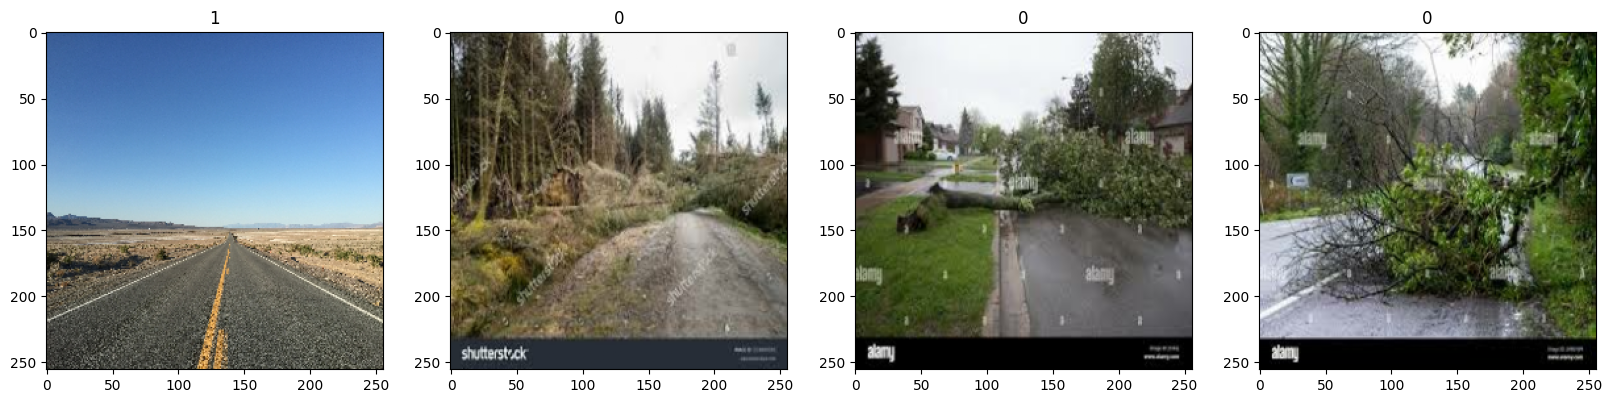

In [32]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

therefore it is observed that 1 is for roads without obstruction
and 0 for roads with obstruction 

# Splitting data

In [11]:
len(data)  #number of batches in total ( where each batch has 32 images ) 

11

In [12]:
train_size=int(len(data)*.7) #training set will be 70% of dataset --> used to train
val_size=int(len(data)*.2)  #validation set will be 70% of dataset --> used to fine tune 
test_size=int(len(data)*.1)  #test set will be 70% of dataset  --> used to finally test it 

In [13]:
print(train_size,val_size,test_size)

7 2 1


In [14]:
train=data.take(train_size) #takes the first 7 batches 
val=data.skip(train_size).take(val_size) #skips the first 7 and takes the 2 after that 
test=data.skip(train_size+val_size).take(test_size) #skips the first 9 and takes the 1 after that 

# Convulutional Neural net for Deep modeling 

In [15]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout

In [16]:
cnn=Sequential()

In [17]:
#added conv layer with 16 filters , 3x3 filter size , stride =1 
cnn.add(Conv2D(16,(3,3),1,activation='relu',input_shape=(256,256,3)))
cnn.add(MaxPooling2D())
#added conv layer with 32 filters , 3x3 filter size ,stride =1
cnn.add(Conv2D(32,(3,3),1,activation='relu'))
cnn.add(MaxPooling2D())
#added conv layer with 16 filters , 3x3 filter size , stride =1
cnn.add(Conv2D(16,(3,3),1,activation='relu'))
cnn.add(MaxPooling2D())
#flattening layer
cnn.add(Flatten())
#passing in through a fully connected NN finally 
cnn.add(Dense(256,activation='relu'))
cnn.add(Dense(1,activation='sigmoid')) 

In [18]:
cnn.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [19]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# Training the CNN 

In [20]:
logdir='logs' #to maintain a record of relevant stats wrt to the model 
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist=cnn.fit(train,epochs=20,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 11s 1s/step - loss: 227.8732 - accuracy: 0.4777 - val_loss: 24.3013 - val_accuracy: 0.4531
Epoch 2/20
7/7 [==============================] - 8s 961ms/step - loss: 5.1344 - accuracy: 0.6205 - val_loss: 0.8532 - val_accuracy: 0.6875
Epoch 3/20
7/7 [==============================] - 8s 992ms/step - loss: 0.4769 - accuracy: 0.8393 - val_loss: 0.3060 - val_accuracy: 0.9062
Epoch 4/20
7/7 [==============================] - 8s 1s/step - loss: 0.1693 - accuracy: 0.9509 - val_loss: 0.1781 - val_accuracy: 0.9531
Epoch 5/20
7/7 [==============================] - 8s 1s/step - loss: 0.1215 - accuracy: 0.9732 - val_loss: 0.0914 - val_accuracy: 0.9844
Epoch 6/20
7/7 [==============================] - 8s 1s/step - loss: 0.0679 - accuracy: 0.9732 - val_loss: 0.0664 - val_accuracy: 1.0000
Epoch 7/20
7/7 [==============================] - 8s 1s/step - loss: 0.0422 - accuracy: 1.0000 - val_loss: 0.0791 - val_accuracy: 0.9844
Epoch 8/20
7/7 [===============

In [21]:
hist.history

{'loss': [227.87319946289062,
  5.134430885314941,
  0.4768812358379364,
  0.16926120221614838,
  0.12154687196016312,
  0.0678570419549942,
  0.04222895950078964,
  0.043642543256282806,
  0.02103874273598194,
  0.010339801199734211,
  0.006009968463331461,
  0.0035319491289556026,
  0.001576665905304253,
  0.0008668709197081625,
  0.0011574228992685676,
  0.0007215952500700951,
  0.000483593757962808,
  0.0006012970698066056,
  0.0003880902368109673,
  0.000274302699835971],
 'accuracy': [0.4776785671710968,
  0.6205357313156128,
  0.8392857313156128,
  0.9508928656578064,
  0.9732142686843872,
  0.9732142686843872,
  1.0,
  0.9955357313156128,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [24.301292419433594,
  0.8531588912010193,
  0.3059845566749573,
  0.17807678878307343,
  0.09137378633022308,
  0.06642304360866547,
  0.0790707990527153,
  0.016606077551841736,
  0.004878144711256027,
  0.0046779396943748,
  0.00417994474992156

plotting the accuracy and loss curve 

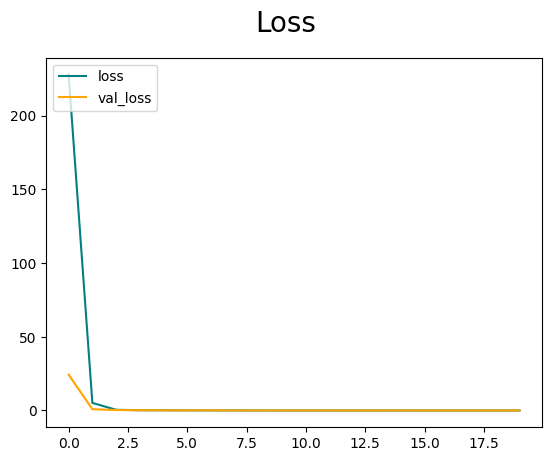

In [22]:
fig=plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc="upper left")
plt.show() 

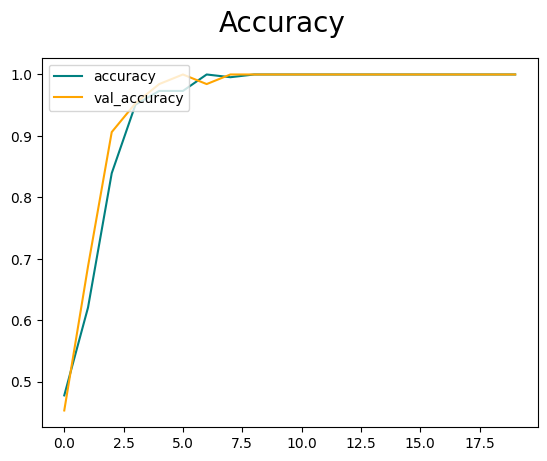

In [23]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluating performance 

In [33]:
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy
pre=Precision()
re=Recall()
acc=BinaryAccuracy()

In [34]:
len(test)

1

In [35]:
#looping through test batch and gathering performance metrics like precision,accuracy,recall 
for batch in test.as_numpy_iterator(): 
    x,y=batch
    yhat=cnn.predict(x)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

1/1 [==============================] - 0s 128ms/step


In [36]:
print(f'Precision:{pre.result().numpy()},Recall:{re.result().numpy()},Accuracy:{acc.result().numpy()}')

Precision:1.0,Recall:1.0,Accuracy:1.0


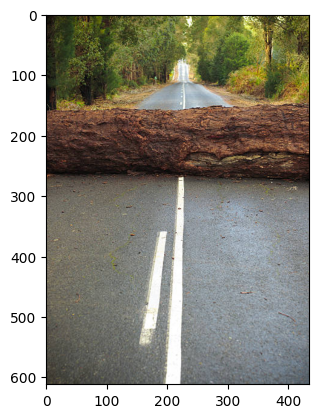

In [60]:
img1=cv2.imread('with_test.jpg')
plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
plt.show()

In [61]:
#before predicting this , the image needs to beresized to the appropriate shape , because we've trained the model with images of particular size 
resize=tf.image.resize(img1,(256,256))

In [62]:
result=cnn.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 29ms/step


In [66]:
if result > 0.5:
    print('road has no obstruction')
else:
    print('road appears to be obstructed')

road has no obstruction


In [64]:
print(result)

[[0.51093817]]
